# Imports and Configuration

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygraphviz as pgv
import glob

from matplotlib.gridspec import GridSpec
from IPython.display import Image

from neighborly import Neighborly
from neighborly.exporter import export_to_json
from neighborly.core.life_event import AllEvents
from neighborly.core.ecs import GameObject
from neighborly.core.relationship import RelationshipManager, Friendship
from neighborly.core.life_event import EventHistory, RandomLifeEvent
from neighborly.utils.common import get_relationship, has_status
from neighborly.components import GameCharacter, Business
from neighborly.core.ecs import Active
from neighborly.components import Name
from neighborly.components.character import Family

import test_neighborly_integration

from speakeasy.components import Respect, Favors, Inventory, Ethnicity, EthnicityValue
from speakeasy.events import NegotiateEvent, TradeEvent, GoodWordEvent, TellAboutEvent, TheftEvent, HelpWithRivalGangEvent, GiveEvent
from speakeasy.events import GainItemEffect, LoseItemEffect, GainRelationshipEffect, LoseRelationshipEffect, GainKnowledgeEffect, TriggerEventEffect
from speakeasy.events import get_associated_business

## Notebook Configuration

In [2]:
SKIP_RUNNING_AB = False
SEED_SIMS_AB = "paradise"
DURATION_SIMS_AB = 25

SKIP_RUNNING_MULTI = False
NUM_SIMS_MULTI = 10
DURATION_SIMS_MULTI = 15

FILE_OUTPUT_LOCATION = "./notebook_outputs/"

# Simulation

We will source simulation data from two pools:

## Comparison Data (AB Test)

The first pool of data is for comparison: run two simulations with the same seed for `DURATION_SIMS_AB` years, one with negotiation, the other without. These are the "AB" sims.

In [3]:
AB_SIMULATION_CONFIGS = [
    {
        "duration": DURATION_SIMS_AB,
        "seed": SEED_SIMS_AB,
        "enable_negotiation": True
    },
    {
        "duration": DURATION_SIMS_AB,
        "seed": SEED_SIMS_AB,
        "enable_negotiation": False
    },
]
NUM_SIMS_AB = len(AB_SIMULATION_CONFIGS)

sims_ab = []
if not SKIP_RUNNING_AB:
  for config in AB_SIMULATION_CONFIGS:
      AllEvents.clear_event_listeners()
      GameObject.clear_event_listeners()
      sims_ab.append(test_neighborly_integration.run_sim_with_negotiation(**config))

Running some initial Speakeasy simulation...
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Double Springs), (Character: Bonny Rookey(3))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Double Springs), (Character: Carey Rookey(4))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Double Springs), (Character: Guadalupe Rookey(7))
MoveResidenceEvent [@ 0001-01-01T00:00:00] (Residence: residence::default::house(2)), (Character: Bonny Rookey(3)), (Character: Carey Rookey(4)), (Character: Guadalupe Rookey(7))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Double Springs), (Character: Carey Marsden(14))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Double Springs), (Character: Wren Marsden(15))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Double Springs), (Character: Dallas Marsden(18))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Double Springs), (Character: Karlotta Marsden(24))
JoinSettlementEvent [@ 0001-01-01T00:00:

In [4]:
for idx, sim in enumerate(sims_ab):
  with open(f"{FILE_OUTPUT_LOCATION}/sim_ab_{sim.config.seed}-{idx}.json", "w") as f:
    f.write(export_to_json(sim))

## Consistency Data (Multiple Seeds)

The second pool of data is to check consistency. We will run multiple (`NUM_SIMS_MULTI`) simulations (with negotiation) for `DURATION_SIMS_MULTI` years. These are the "Multi" sims.

In [5]:
sims_multi = []
if not SKIP_RUNNING_MULTI:
    for idx in range(NUM_SIMS_MULTI):
        AllEvents.clear_event_listeners()
        GameObject.clear_event_listeners()
        sims_multi.append(test_neighborly_integration.run_sim_with_negotiation(duration=DURATION_SIMS_MULTI, seed=idx, enable_negotiation=True))

Running some initial Speakeasy simulation...
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Perryville), (Character: Boyce Elzey(3))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Perryville), (Character: Monroe Elzey(4))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Perryville), (Character: Beryle Elzey(7))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Perryville), (Character: Andri Elzey(13))
MoveResidenceEvent [@ 0001-01-01T00:00:00] (Residence: residence::default::house(2)), (Character: Boyce Elzey(3)), (Character: Monroe Elzey(4)), (Character: Beryle Elzey(7)), (Character: Andri Elzey(13))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Perryville), (Character: Lorene Densmore(22))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Perryville), (Character: Darian Densmore(23))
JoinSettlementEvent [@ 0001-01-01T00:00:00] (Settlement: Perryville), (Character: Mortimer Densmore(27))
MoveResidenceEvent [@ 0001-01-01T00:00:00] (R

In [6]:
for idx, sim in enumerate(sims_multi):
  with open(f"{FILE_OUTPUT_LOCATION}/sim_multi_{sim.config.seed}-{idx}.json", "w") as f:
    f.write(export_to_json(sim))

# Number Crunching Code

### Count and composition of each event type 

In [7]:
#calculate a dictionary mapping each event type to a count
def calculate_event_type_counts(sim : Neighborly):
    keys = [NegotiateEvent, TradeEvent, GoodWordEvent, TellAboutEvent, TheftEvent, HelpWithRivalGangEvent]
    event_counts = dict([(key, 0) for key in keys])
    all_events = sim.world.get_resource(AllEvents)
    for event in all_events:
        if type(event) in keys:
            event_counts[type(event)] += 1
    return event_counts

calculate_event_type_counts(sims_ab[0])

{speakeasy.events.NegotiateEvent: 35,
 speakeasy.events.TradeEvent: 30,
 speakeasy.events.GoodWordEvent: 32,
 speakeasy.events.TellAboutEvent: 8,
 speakeasy.events.TheftEvent: 37,
 speakeasy.events.HelpWithRivalGangEvent: 30}

In [8]:
#tell if two gameobjects (assumed characters) are in the same family or have the same ethnicity
def same_family(a : GameObject, b : GameObject):
    return has_status(get_relationship(a, b), Family)
def same_ethnicity(a : GameObject, b: GameObject):
    return a.get_component(Ethnicity).ethnicity == b.get_component(Ethnicity).ethnicity

#return a mapping from each event type to a count per category based on identity of participants
def calculate_event_composition(sim : Neighborly):
    keys = [NegotiateEvent, TradeEvent, GoodWordEvent, TellAboutEvent, TheftEvent, HelpWithRivalGangEvent]
    calculate_event_composition.categories = ["Different Family / Different Ethnicity", "Different Family / Same Ethnicity", "Same Family / Different Ethnicity", "Same Family / Same Ethnicicty"]
    event_compositions = dict([(key, [0 for cat in calculate_event_composition.categories]) for key in keys])
    all_events = sim.world.get_resource(AllEvents)
    for event in all_events:

        if type(event) in keys:
            other = event["Other"]
            if type(event) is TheftEvent:
                if not event["Other"].get_component(Business).owner:
                    continue
                other = sim.world.get_gameobject(event["Other"].get_component(Business).owner)
            if type(event) is GoodWordEvent:
                other = event["Subject"]
            is_same_family = same_family(event["Initiator"], other)
            is_same_ethnicity = same_ethnicity(event["Initiator"], other)
                
            event_compositions[type(event)][ is_same_family * 2 + is_same_ethnicity ] += 1

    return event_compositions

calculate_event_composition(sims_ab[0])

{speakeasy.events.NegotiateEvent: [24, 5, 6, 0],
 speakeasy.events.TradeEvent: [0, 21, 9, 0],
 speakeasy.events.GoodWordEvent: [0, 21, 3, 8],
 speakeasy.events.TellAboutEvent: [5, 1, 2, 0],
 speakeasy.events.TheftEvent: [17, 13, 1, 6],
 speakeasy.events.HelpWithRivalGangEvent: [0, 11, 0, 19]}

### Distributions of each item

In [9]:
#return name, occupation, and count of each item per active character.
def calculate_item_distributions(sim : Neighborly):
    item_dists = {}
    item_owners = sim.world.get_components((Active, GameCharacter, Inventory))
    num_item_owners = len(item_owners)
    names_of_item_owners = []
    business_types = set({'None'})

    #create all the keys in the item_dists (basically what items are in the sim?) and setup axis labels per character
    #also track the kinds of businesses present
    for character_index in range(num_item_owners):
        (id, (active, gamechar, inventory)) = item_owners[character_index]
        
        name_to_append = gamechar.full_name

        if biz := get_associated_business(gamechar.gameobject):
            bizname = biz.gameobject.get_component(Name).value
            relationship_to_business_label = "?"
            if biz.owner == id:
                relationship_to_business_label = "O"
            elif id in biz.get_employees():
                relationship_to_business_label = "E"

            name_to_append += f" [{relationship_to_business_label}@{bizname}]"
            business_types.add(bizname)
        else:
            name_to_append += " [None]"

        names_of_item_owners.append(name_to_append)
        
        for key in inventory.items:
            if key not in item_dists:
                item_dists[key] = []

    #count the # of each item from above in the inventory of each character.
    for key in item_dists:
        for character_index in range(num_item_owners):
            (id, (active, gamechar, inventory)) = item_owners[character_index]            
            count = 0
            if key in inventory.items:
                count = inventory.items[key]
            item_dists[key].append(count)

    return (names_of_item_owners, item_dists, business_types)

calculate_item_distributions(sims_ab[0])

(['Marty Marsden [O@Bar]',
  'Mose Nutley [E@Brewery]',
  'Bonny Rookey [O@Brewery]',
  'Carey Rookey [E@Brewery]',
  'Justice Heather [O@Brewery]',
  'Kirby Heather [E@Brewery]',
  'Bud Harmon [E@Brewery]',
  'Sawyere Harmon [E@Bar]',
  'Rodger Heather [O@CornFarm]',
  'Carey Marsden [O@Brewery]',
  'Wren Marsden [O@Brewery]',
  'Dallas Marsden [E@CornFarm]',
  'Franky Heather [E@Bar]',
  'Tore Nutley [E@Brewery]',
  'Hildegarde Nutley [E@CornFarm]',
  'Karlotta Marsden [E@Brewery]',
  'Alva Heather [E@Brewery]'],
 {'booze': [0, 9, 0, 0, 5, 7, 1, 3, 0, 3, 0, 2, 7, 4, 1, 11, 1],
  'money': [0, 1, 0, 1, 0, 2, 5, 6, 0, 0, 0, 6, 1, 2, 5, 6, 1],
  'corn': [0, 3, 0, 3, 0, 4, 3, 0, 0, 0, 0, 1, 0, 4, 8, 1, 0]},
 {'Bar', 'Brewery', 'CornFarm', 'None'})

### Trade composition

In [10]:
#occurence count of each possible type of item exchange (exchanges include trades and negotiations)
def calculate_trade_count_by_type(sim: Neighborly):
    all_events = sim.world.get_resource(AllEvents)
    all_trades = [e for e in all_events if type(e) == TradeEvent]
    trade_pairs = ["-".join(sorted([trade.initiators_item, trade.others_item])) for trade in all_trades]

    all_negotiations = [e for e in all_events if type(e) == NegotiateEvent]
    for e in all_negotiations:
        negotiated_trade_pairs = []
        event_pairs_to_skip = []
        for a in e.agreement:
            for b in e.agreement:
                if (set([a.val.get_id(), b.val.get_id()]) not in event_pairs_to_skip) and (type(a.val) is GiveEvent and type(b.val) is GiveEvent) and a.val["Initiator"] != b.val["Initiator"]:
                    trade_pair = "-".join(sorted([a.val.item, b.val.item]))
                    negotiated_trade_pairs.append(trade_pair)
                    event_pairs_to_skip.append(set([a.val.get_id(), b.val.get_id()]))
        trade_pairs.extend(negotiated_trade_pairs)

    trade_pair_counts = [(pair, trade_pairs.count(pair)) for pair in set(trade_pairs)]

    return trade_pair_counts
  
calculate_trade_count_by_type(sims_ab[0])

[('corn-money', 11),
 ('booze-booze', 10),
 ('corn-corn', 4),
 ('booze-corn', 28),
 ('booze-money', 7),
 ('money-money', 1)]

### Histogram of respect values

In [11]:
#get values of every relationship, in the three facets of Respect, Friendship, and Favors owed
def calculate_relationship_values(sim : Neighborly):
    relationship_values = {
        Respect.__name__ : [],
        Friendship.__name__ : [],
        Favors.__name__ : []
    }

    relationship_havers = sim.world.get_components((Active, GameCharacter, RelationshipManager))
    for (id, (_, char, rmanager)) in relationship_havers:
        for (id2, (_, char2, rmanager)) in  relationship_havers:
            if id == id2:
                continue
            rel = get_relationship(sim.world.get_gameobject(id), sim.world.get_gameobject(id2))
            respect = rel.get_component(Respect).get_value()
            friendship = rel.get_component(Friendship).get_value()
            favors = rel.get_component(Favors).favors
            
            relationship_values[Respect.__name__].append(respect)
            relationship_values[Friendship.__name__].append(friendship)
            relationship_values[Favors.__name__].append(favors)

    return relationship_values

calculate_relationship_values(sims_ab[0])

{'Respect': [4,
  5,
  -6,
  -6,
  -5,
  -5,
  -5,
  -5,
  5,
  -4,
  -3,
  -8,
  -5,
  -5,
  7,
  -5,
  4,
  6,
  -5,
  -5,
  -5,
  -5,
  -5,
  -5,
  -5,
  8,
  -5,
  -5,
  3,
  -5,
  10,
  -5,
  7,
  6,
  -5,
  -5,
  -6,
  -11,
  -5,
  -5,
  -4,
  4,
  -5,
  -6,
  -5,
  -5,
  5,
  -5,
  -6,
  -5,
  -5,
  -5,
  -5,
  7,
  -6,
  -5,
  -5,
  -5,
  -5,
  7,
  -5,
  -5,
  -5,
  -5,
  -6,
  -5,
  -5,
  -5,
  -5,
  -6,
  -5,
  -3,
  -5,
  -5,
  -5,
  11,
  -4,
  -5,
  -5,
  -11,
  -5,
  -5,
  -6,
  -5,
  -5,
  -5,
  8,
  -4,
  6,
  -5,
  -4,
  -5,
  10,
  4,
  -5,
  10,
  -5,
  -5,
  -5,
  9,
  -5,
  -5,
  -5,
  -6,
  -6,
  -5,
  -5,
  6,
  -7,
  -5,
  -5,
  -5,
  -5,
  -5,
  -5,
  -6,
  -5,
  7,
  -5,
  -5,
  6,
  -5,
  -5,
  -5,
  8,
  -5,
  -5,
  -5,
  -5,
  -5,
  -5,
  -5,
  -5,
  -3,
  -6,
  -5,
  -5,
  -5,
  5,
  -2,
  -5,
  -6,
  -5,
  -1,
  8,
  -5,
  -4,
  -5,
  -5,
  -5,
  -6,
  5,
  -5,
  -5,
  -4,
  -5,
  5,
  -5,
  9,
  -5,
  -5,
  10,
  4,
  -5,
  -5,
  -5,
  -5,
  -5,
  -5,
 

### Respect correlates

In [12]:
#get values of total incoming respect, wealth, favors owed to, and event initiation counts for each actice character
def calculate_respect_and_other_things_per_character(sim : Neighborly):
  wealth_array = []
  respect_array = []
  favors_array = []
  event_initiation_counts_array = []
  event_counts_keys = []
  characters = sim.world.get_components((Active, GameCharacter, RelationshipManager, Inventory))
  for character_index in range(len(characters)):
    (id, (active, gamechar, relationship_manager, inventory)) = characters[character_index]
    character_object = sim.world.get_gameobject(id)

    #calculate wealth
    wealth_values = [i for i in inventory.items.values()]
    wealth = sum(wealth_values)
    wealth_array.append(wealth)

    #calculate frequency of actions
    history = character_object.get_component(EventHistory)
    event_type_counts = {}
    for event in history:
        if type(event) in [NegotiateEvent, TradeEvent, GoodWordEvent, TellAboutEvent, TheftEvent, HelpWithRivalGangEvent]:
          if type(event).__name__ not in event_type_counts:
              event_type_counts[type(event).__name__] = 1
          else:
              event_type_counts[type(event).__name__] += 1
          event_counts_keys.append(type(event).__name__)
    event_initiation_counts_array.append(event_type_counts)

    #calculate respect
    respect_values = [sim.world.get_gameobject(i).get_component(Respect).get_value() for i in relationship_manager.incoming.values()]
    respect = sum(respect_values)
    respect_array.append(respect)

    favors_values = [sim.world.get_gameobject(i).get_component(Favors).favors for i in relationship_manager.incoming.values()]
    favors = sum(favors_values)
    favors_array.append(favors)

  return (respect_array, wealth_array, favors_array, event_initiation_counts_array, list(set(event_counts_keys)))

calculate_respect_and_other_things_per_character(sims_ab[0])

([-17,
  1,
  -27,
  -33,
  -70,
  -10,
  -47,
  -31,
  -34,
  -32,
  -75,
  -31,
  -17,
  -40,
  -57,
  -26,
  -27],
 [0, 13, 0, 4, 5, 13, 9, 9, 0, 3, 0, 9, 8, 10, 14, 18, 2],
 [7, 2, 3, 0, 1, 3, 5, 0, 3, 1, 2, 2, 5, 2, 0, 2, 2],
 [{'GoodWordEvent': 6,
   'HelpWithRivalGangEvent': 3,
   'NegotiateEvent': 2,
   'TheftEvent': 1},
  {'TradeEvent': 3,
   'HelpWithRivalGangEvent': 4,
   'NegotiateEvent': 2,
   'GoodWordEvent': 2},
  {'HelpWithRivalGangEvent': 1,
   'NegotiateEvent': 3,
   'GoodWordEvent': 3,
   'TheftEvent': 2},
  {'TheftEvent': 4, 'NegotiateEvent': 3, 'TradeEvent': 3, 'GoodWordEvent': 2},
  {'TradeEvent': 3, 'TheftEvent': 1, 'NegotiateEvent': 3, 'GoodWordEvent': 1},
  {'GoodWordEvent': 1,
   'TheftEvent': 2,
   'TradeEvent': 3,
   'HelpWithRivalGangEvent': 2,
   'TellAboutEvent': 1},
  {'NegotiateEvent': 3,
   'TheftEvent': 3,
   'TradeEvent': 1,
   'HelpWithRivalGangEvent': 5,
   'GoodWordEvent': 2},
  {'TradeEvent': 2, 'GoodWordEvent': 1, 'TheftEvent': 2, 'NegotiateEven

### Mutual respect graph

c:\Program Files (x86)\Python310\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'Justice Heather', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


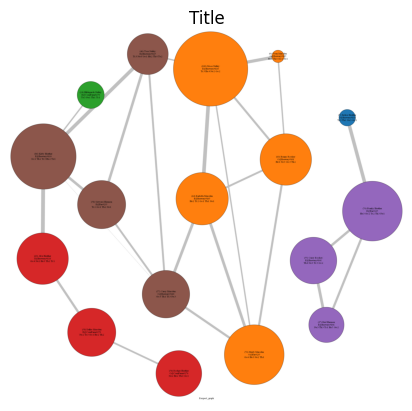

In [13]:
matplotlib_defaults = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
node_colors = dict([(list(EthnicityValue)[i],matplotlib_defaults[i]) for i in range(len(matplotlib_defaults))])

def make_relationship_graph(sim : Neighborly, facet_to_test):
   relationship_graph = pgv.AGraph(strict=False, directed=False)
   relationship_graph.graph_attr["label"] = f"{facet_to_test.__name__}_graph"
   relationship_graph.graph_attr["outputorder"] = 'edgesfirst'
   relationship_havers = sim.world.get_components((Active, GameCharacter, RelationshipManager))
   num_relationship_havers = len(relationship_havers)

   incoming_respect_array = []
   for haver in relationship_havers:
      (id, (active, gamechar, relationship_manager)) = haver
      respect_values = [sim.world.get_gameobject(i).get_component(facet_to_test).get_value() for i in relationship_manager.incoming.values()]
      respect = sum(respect_values)
      incoming_respect_array.append(respect)

   incoming_respect_array = np.array(incoming_respect_array)
   incoming_respect_array -= min(incoming_respect_array)
   incoming_respect_array = [20 + 100*(r/max(incoming_respect_array)) for r in incoming_respect_array]

   for character_index in range(num_relationship_havers):
      (id, (active, gamechar, relationship_manager)) = relationship_havers[character_index]
      character_object = sim.world.get_gameobject(id)
      
      node_label = f"{gamechar.full_name}"

      #mark node with business info
      if biz := get_associated_business(character_object):
         relationship_to_business_label = "?"
         if biz.owner == id:
               relationship_to_business_label = "O"
         elif id in biz.get_employees():
               relationship_to_business_label = "E"
         node_label += f"\n{relationship_to_business_label}@{biz.gameobject.get_component(Name).value}#{biz.gameobject._id}"

      #mark node with event history info
      history = character_object.get_component(EventHistory)
      event_type_counts = {}
      for event in history:
         if type(event) in [NegotiateEvent, TradeEvent, GoodWordEvent, TellAboutEvent, TheftEvent, HelpWithRivalGangEvent]:
            if type(event).__name__[0:2] not in event_type_counts:
               event_type_counts[type(event).__name__[0:2]] = 1
            else:
               event_type_counts[type(event).__name__[0:2]] += 1
      node_label += f"\n" + " ".join([f"{k}:{event_type_counts[k]}" for k in event_type_counts])

      #mark node with demographic info
      relationship_graph.add_node(gamechar.full_name)
      node = relationship_graph.get_node(gamechar.full_name)
      node.attr["label"] = f"({round(incoming_respect_array[character_index])-20}) " + node_label
      node.attr["style"] = "filled"
      node.attr["fillcolor"] = node_colors[character_object.get_component(Ethnicity).ethnicity]
      node.attr["width"] = incoming_respect_array[character_index]/20
      node.attr["height"] = incoming_respect_array[character_index]/20
      node.attr["shape"] = "circle"
      node.attr["fixedsize"] = True


   for character_index in range(num_relationship_havers):
      (id, (active, gamechar, relationship_manager)) = relationship_havers[character_index]
      for target_id in relationship_manager.outgoing.keys():
         if id == target_id:
            continue
         
         target_gameobject = sim.world.get_gameobject(target_id)
         target_character = target_gameobject.get_component(GameCharacter)
         relationship_weight = get_relationship(sim.world.get_gameobject(id), target_gameobject).get_component(facet_to_test).get_value()
         
         #if reverse edge already existed, add the weights
         if relationship_graph.has_edge(target_character.full_name, gamechar.full_name):
            relationship_weight += int(relationship_graph.get_edge(target_character.full_name, gamechar.full_name).attr['weight'])
            relationship_graph.remove_edge(target_character.full_name, gamechar.full_name)
         
         if relationship_graph.has_node(gamechar.full_name) and relationship_graph.has_node(target_character.full_name):
            pen_width = relationship_weight
            pen_color = 'grey'
            """if pen_width < 0:
               pen_width = -pen_width
               pen_color = 'lightsalmon'"""
            relationship_graph.add_edge(gamechar.full_name, target_character.full_name, weight = relationship_weight, color = pen_color, penwidth = str(pen_width))#, len = 1/relationship_weight)#, label=relationship_weight)
  
   return relationship_graph

def display_graph(graph : pgv.AGraph, suffix, title="Title"):
  LAYOUTS_TO_TRY = ["neato", "fdp", "sfdp", "osage"]
  LAYOUT_CHOICE = 1

  graph.graph_attr['overlap'] = 'scale'
  graph_filename = f"{FILE_OUTPUT_LOCATION}/{graph.graph_attr['label'].lower()}_{suffix}.png"
  graph.layout(prog=LAYOUTS_TO_TRY[LAYOUT_CHOICE])
  graph.draw(graph_filename, prog=LAYOUTS_TO_TRY[0])
  img = plt.imread(graph_filename)
  plt.imshow(img)
  plt.axis('off')
  plt.title(title)
  #display(Image(filename=graph_filename, height=500, width=500))

display_graph(make_relationship_graph(sims_ab[0], Respect), 'test')

c:\Program Files (x86)\Python310\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'Unemployed&Black', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


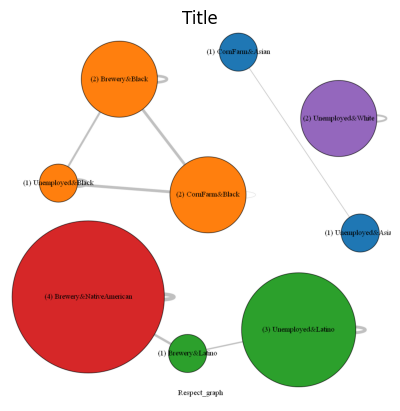

In [14]:
#different version of the above that shows business owners instead of individuals. uses averaging to aggregate mutual respect for the business nodes.
def make_business_relationship_graph(sims : list[Neighborly], facet_to_test):
   relationship_graph = pgv.AGraph(strict=False, directed=False)
   relationship_graph.graph_attr["label"] = f"{facet_to_test.__name__}_graph"
   relationship_graph.graph_attr["outputorder"] = 'edgesfirst'
   for sim in sims:
      relationship_havers = sim.world.get_components((Active, GameCharacter, RelationshipManager))
      num_relationship_havers = len(relationship_havers)

      incoming_respect_array = []
      for haver in relationship_havers:
         (id, (active, gamechar, relationship_manager)) = haver
         respect_values = [sim.world.get_gameobject(i).get_component(facet_to_test).get_value() for i in relationship_manager.incoming.values()]
         respect = sum(respect_values)
         incoming_respect_array.append(respect)

      incoming_respect_array = np.array(incoming_respect_array)
      incoming_respect_array -= min(incoming_respect_array)
      incoming_respect_array = [20 + 100*(r/max(incoming_respect_array)) for r in incoming_respect_array]

      for character_index in range(num_relationship_havers):
         (id, (active, gamechar, relationship_manager)) = relationship_havers[character_index]
         character_object = sim.world.get_gameobject(id)
         
         biz = get_associated_business(gamechar.gameobject)
         full_business_name = biz.gameobject.get_component(Name).value if biz else "Unemployed"
         
         node_label = f"{full_business_name}&{gamechar.gameobject.get_component(Ethnicity).ethnicity.name}"

         #mark node with demographic info
         count = 0
         if not relationship_graph.has_node(node_label):
            relationship_graph.add_node(node_label)
         else:
            count = node.character_count
         node = relationship_graph.get_node(node_label)
         node.character_count = count + 1
         node.attr["label"] = f"({node.character_count}) " + node_label
         node.attr["style"] = "filled"
         node.attr["fillcolor"] = node_colors[character_object.get_component(Ethnicity).ethnicity]
         node.attr["width"] = node.character_count / len(sims)
         node.attr["height"] = node.character_count / len(sims)
         node.attr["shape"] = "circle"
         node.attr["fixedsize"] = True


      for character_index in range(num_relationship_havers):
         (id, (active, gamechar, relationship_manager)) = relationship_havers[character_index]
         for target_id in relationship_manager.outgoing.keys():
            if id == target_id:
               continue
            
            target_gameobject = sim.world.get_gameobject(target_id)
            target_character = target_gameobject.get_component(GameCharacter)
            relationship_weight = get_relationship(sim.world.get_gameobject(id), target_gameobject).get_component(facet_to_test).get_value()
            
            from_biz = get_associated_business(gamechar.gameobject)
            target_biz = get_associated_business(target_gameobject)
            from_biz_name = from_biz.gameobject.get_component(Name).value if from_biz else "Unemployed"
            target_biz_name = target_biz.gameobject.get_component(Name).value if target_biz else "Unemployed"

            from_node_label = f"{from_biz_name}&{gamechar.gameobject.get_component(Ethnicity).ethnicity.name}"
            target_node_label = f"{target_biz_name}&{target_character.gameobject.get_component(Ethnicity).ethnicity.name}"

            #keep track of count for averaging
            count=0
            old_weight=0

            #if reverse edge already existed, add the weights
            if relationship_graph.has_edge(target_node_label, from_node_label):
               old_weight += float(relationship_graph.get_edge(target_node_label, from_node_label).attr['weight'])
               if c:=relationship_graph.get_edge(target_node_label, from_node_label).attr['count']:
                  count += int(c)
               relationship_graph.remove_edge(target_node_label, from_node_label)
            
            #if edge already existed, add the weights
            if relationship_graph.has_edge(from_node_label, target_node_label):
               old_weight += float(relationship_graph.get_edge(from_node_label, target_node_label).attr['weight'])
               if c:=relationship_graph.get_edge(from_node_label, target_node_label).attr['count']:
                  count += int(c)
               relationship_graph.remove_edge(from_node_label, target_node_label)
            
            new_weight = (old_weight * count + relationship_weight) / (count+1)

            if relationship_graph.has_node(from_node_label) and relationship_graph.has_node(target_node_label):
               pen_width = new_weight
               pen_color = 'grey'
               """if pen_width < 0:
                  pen_width = -pen_width
                  pen_color = 'lightsalmon'"""
               relationship_graph.add_edge(from_node_label, target_node_label, weight = new_weight, color = pen_color, penwidth = str(pen_width))
               relationship_graph.get_edge(from_node_label, target_node_label).attr['count'] = count + 1
               #relationship_graph.get_edge(from_node_label, target_node_label).attr['label'] = f"{count}"
   
   return relationship_graph

display_graph(make_business_relationship_graph([sim], Respect), 'test')

# Visualizations

### 1. What events are occurring?

First we simply look at the count of each event type.

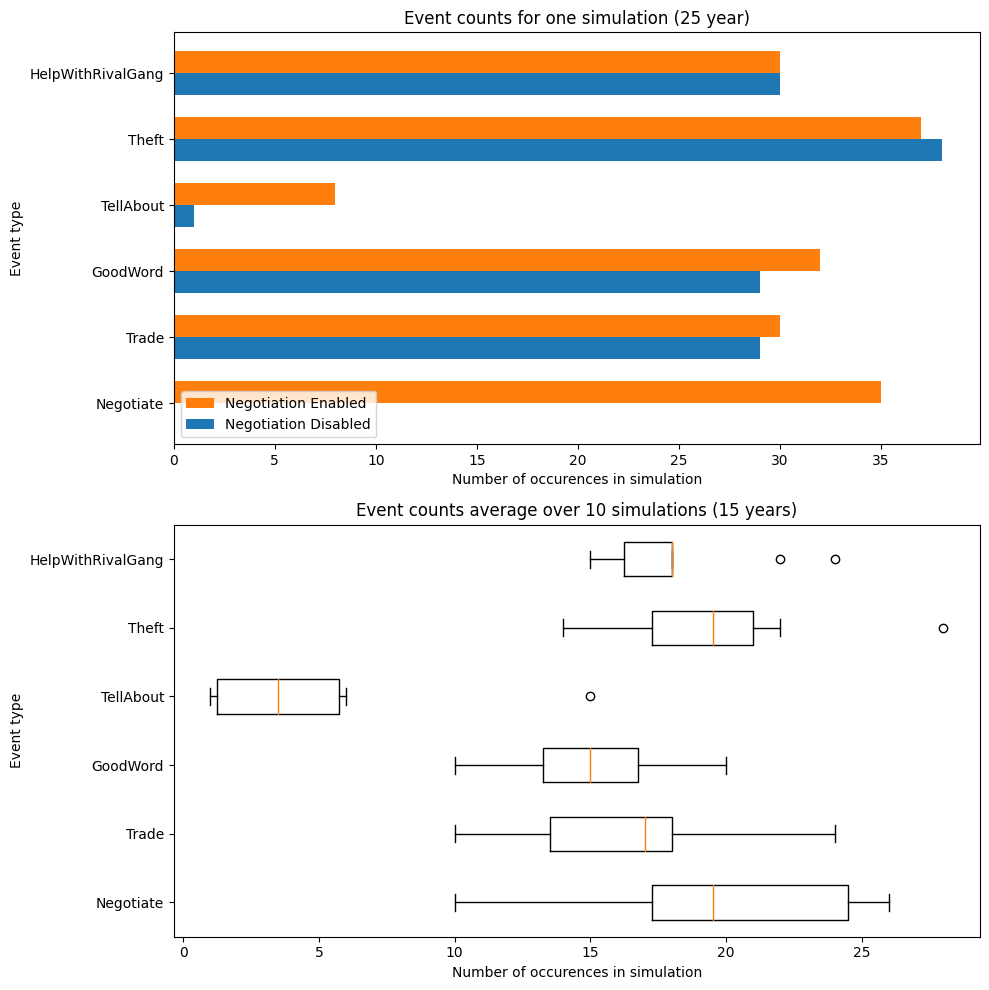

In [15]:
def show_event_counts():
  fig = plt.figure(figsize=(10,10))
  bar_width = 0.5
  bar_padding = 0.5

  plt.subplot(2,1,1)
  plt.title(f"Event counts for one simulation ({DURATION_SIMS_AB} year)")
  counts_a = calculate_event_type_counts(sims_ab[0])
  counts_b = calculate_event_type_counts(sims_ab[1])

  positions = np.arange(len(counts_a))
  plt.barh(y=positions*(1+bar_padding) - bar_width/2, tick_label=[k.__name__[:-5] for k in counts_b], width=[counts_b[k] for k in counts_b], height=bar_width, label="Negotiation Disabled", align= "edge")
  plt.barh(y=positions*(1+bar_padding) + bar_width/2, tick_label=[k.__name__[:-5] for k in counts_a], width=[counts_a[k] for k in counts_a], height=bar_width, label="Negotiation Enabled", align="edge")

  handles, labels = plt.gca().get_legend_handles_labels()
  plt.legend([handles[1], handles[0]],[labels[1], labels[0]])
  plt.xlabel("Number of occurences in simulation")
  plt.ylabel("Event type")

  plt.subplot(2,1,2)
  plt.title(f"Event counts average over {NUM_SIMS_MULTI} simulations ({DURATION_SIMS_MULTI} years)")
  counts_per_sim = [calculate_event_type_counts(sim) for sim in sims_multi]
  plt.boxplot([[count[label] for count in counts_per_sim] for label in counts_per_sim[0]], vert=False, labels=[k.__name__[:-5] for k in counts_per_sim[0]])

  plt.xlabel("Number of occurences in simulation")
  plt.ylabel("Event type")
  plt.tight_layout()
  plt.savefig(FILE_OUTPUT_LOCATION + "/event_counts.png")

show_event_counts()


Next let's look at the composition of each event type. "Composition" means we compare the initiator to the other party in the event. We categorize them depending on their family and ethnicity.

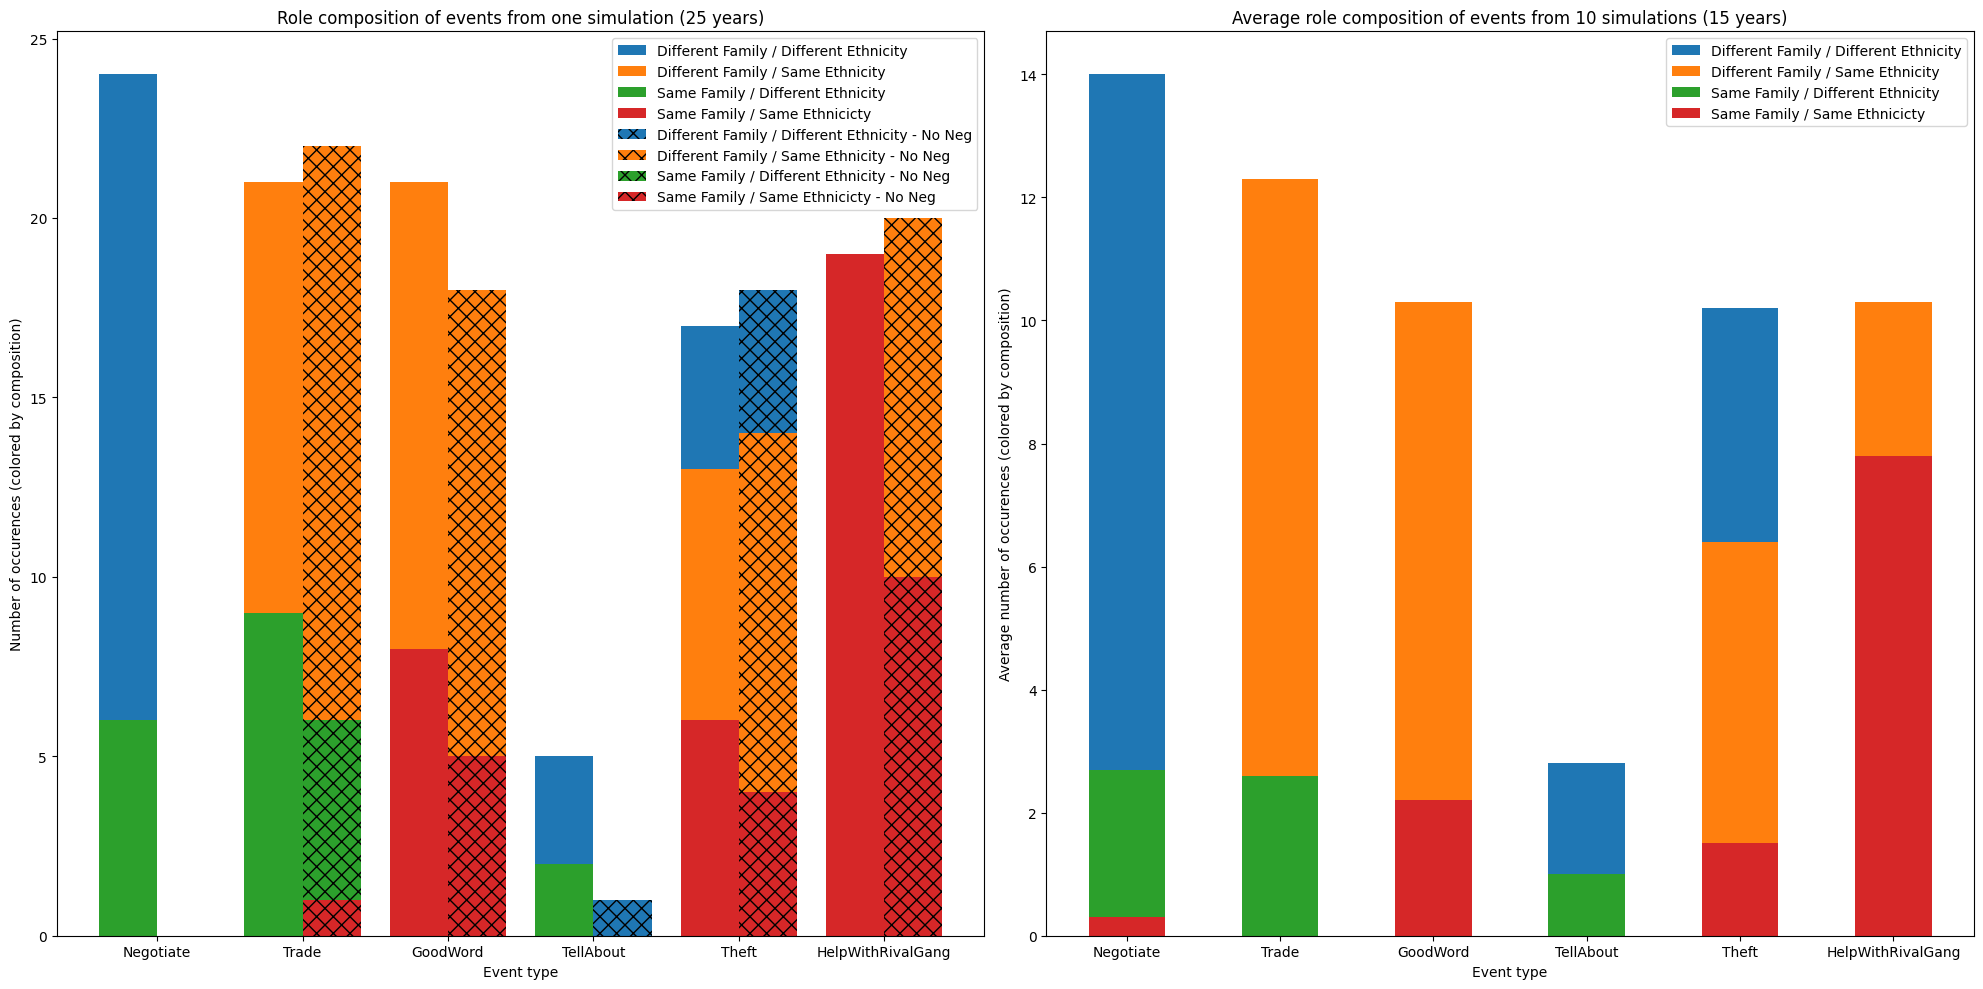

In [16]:
def show_event_compositions():
    fig = plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    bar_width = 0.5
    bar_padding = 0.25

    comps_a = calculate_event_composition(sims_ab[0])
    comps_b = calculate_event_composition(sims_ab[1])
    positions = np.arange(len(comps_a))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for idx, category in enumerate(calculate_event_composition.categories):
        plt.bar(x=positions*(1+bar_padding) - bar_width/2, width=bar_width, height=[comps_a[event_key][idx] for event_key in comps_a], tick_label=[event_key.__name__[:-5] for event_key in comps_a], align="edge", color = colors[idx])
    
    for idx, category in enumerate(calculate_event_composition.categories):
        plt.bar(x=positions*(1+bar_padding) + bar_width/2, width=bar_width, height=[comps_b[event_key][idx] for event_key in comps_b], tick_label=[event_key.__name__[:-5] for event_key in comps_b], align="edge", color = colors[idx], hatch="xx")
    
    labels = calculate_event_composition.categories
    labels.extend([cat + " - No Neg" for cat in calculate_event_composition.categories])
    plt.legend(labels)
    plt.title(f"Role composition of events from one simulation ({DURATION_SIMS_AB} years)")
    plt.xlabel("Event type")
    plt.ylabel("Number of occurences (colored by composition)")

    plt.subplot(1,2,2)

    comps_multi = [calculate_event_composition(sim) for sim in sims_multi]

    for idx, category in enumerate(calculate_event_composition.categories):
        data = np.array([[comp[event_key][idx] for event_key in comp] for comp in comps_multi])
        data = np.average(data, axis=0)
        plt.bar(x=positions, width=bar_width, height=data, tick_label=[event_key.__name__[:-5] for event_key in comps_multi[0]], align="center", color = colors[idx])
    
    plt.legend(calculate_event_composition.categories)
    plt.title(f"Average role composition of events from {NUM_SIMS_MULTI} simulations ({DURATION_SIMS_MULTI} years)")
    
    plt.xlabel("Event type")
    plt.ylabel("Average number of occurences (colored by composition)")
    plt.tight_layout()
    plt.savefig(FILE_OUTPUT_LOCATION + "event_compositions.png")

show_event_compositions()

### 2. What is happening in the simulated economy?

First, for the AB sims, let's inspect the distribution of items per character.

C:\Users\jnani\AppData\Local\Temp\ipykernel_36396\2901360932.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


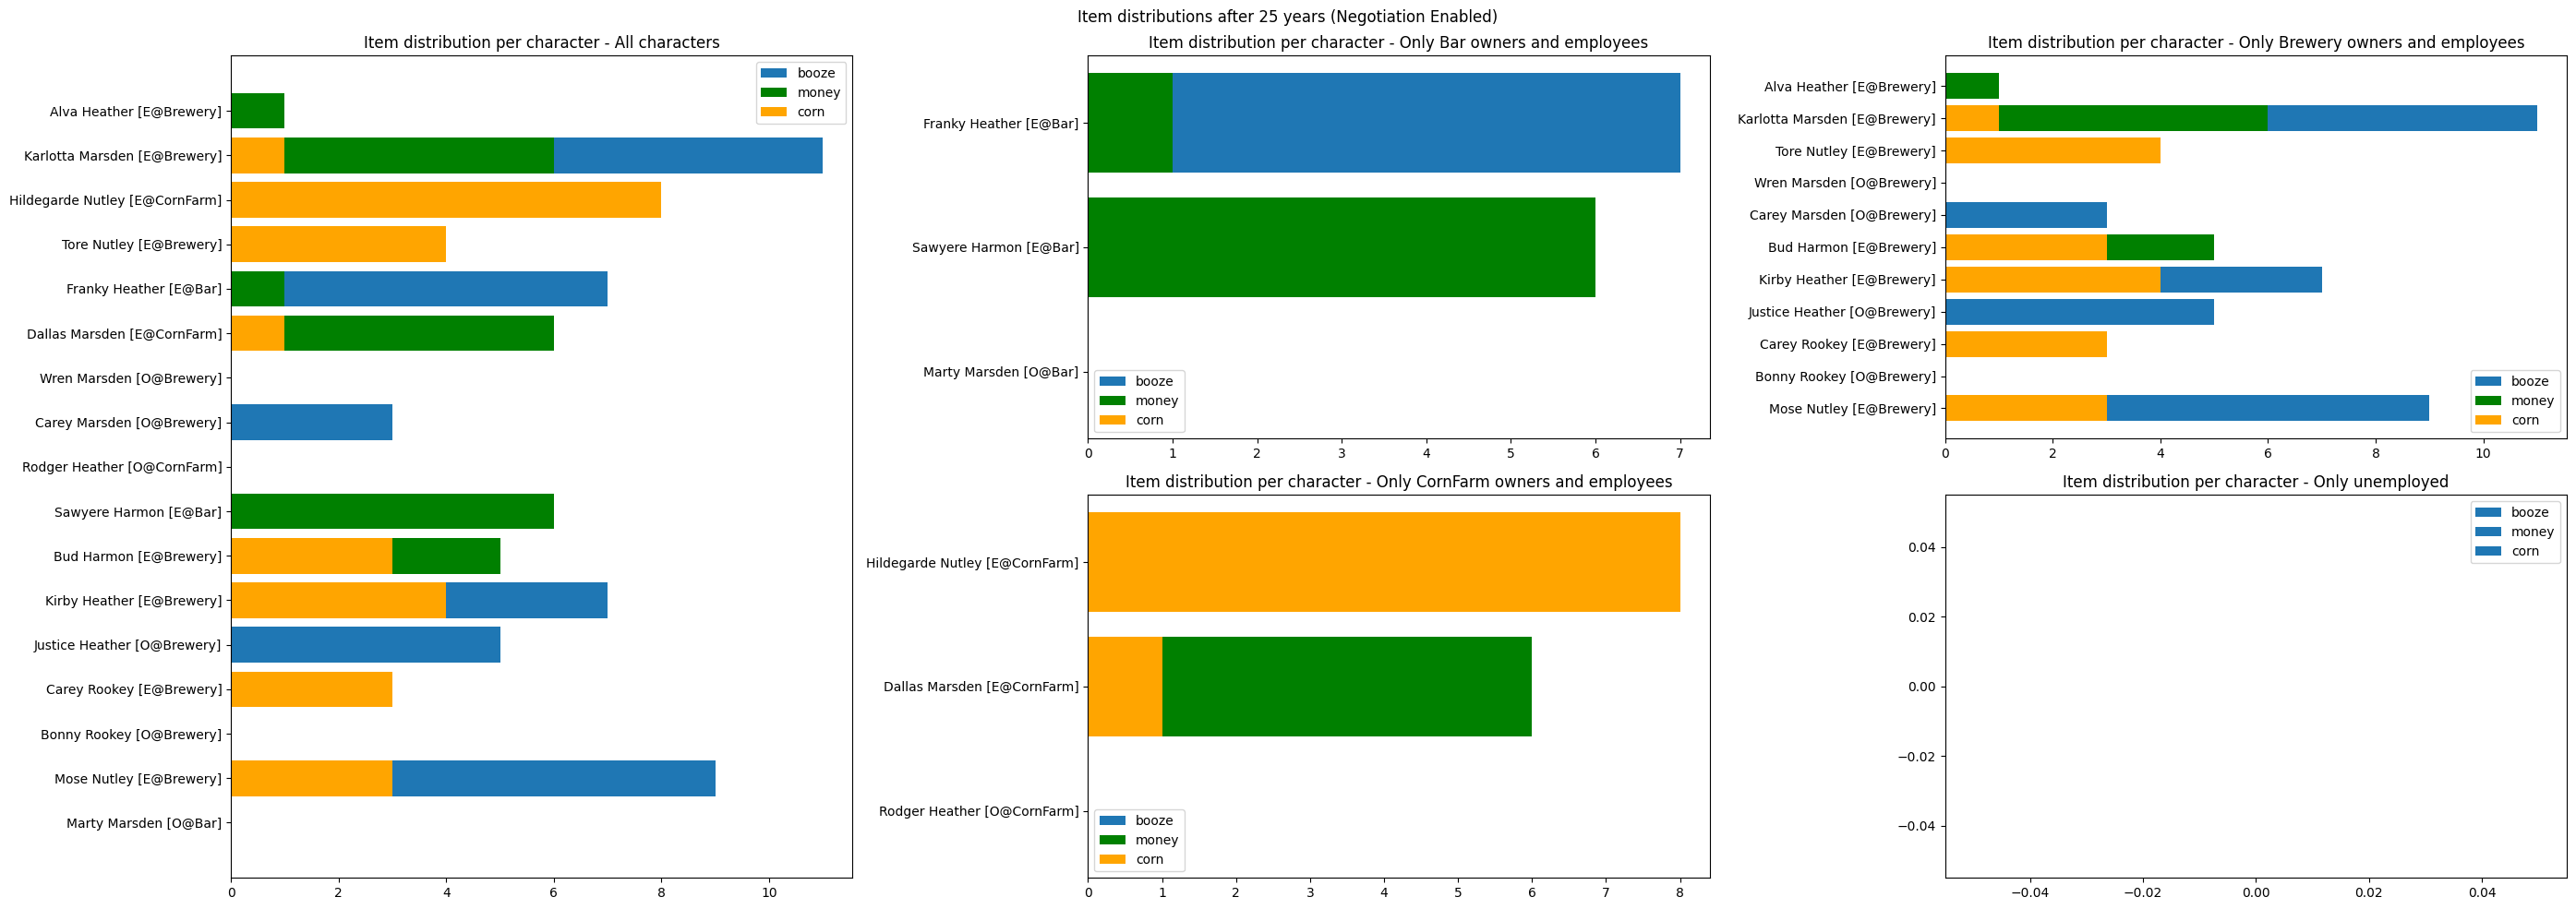

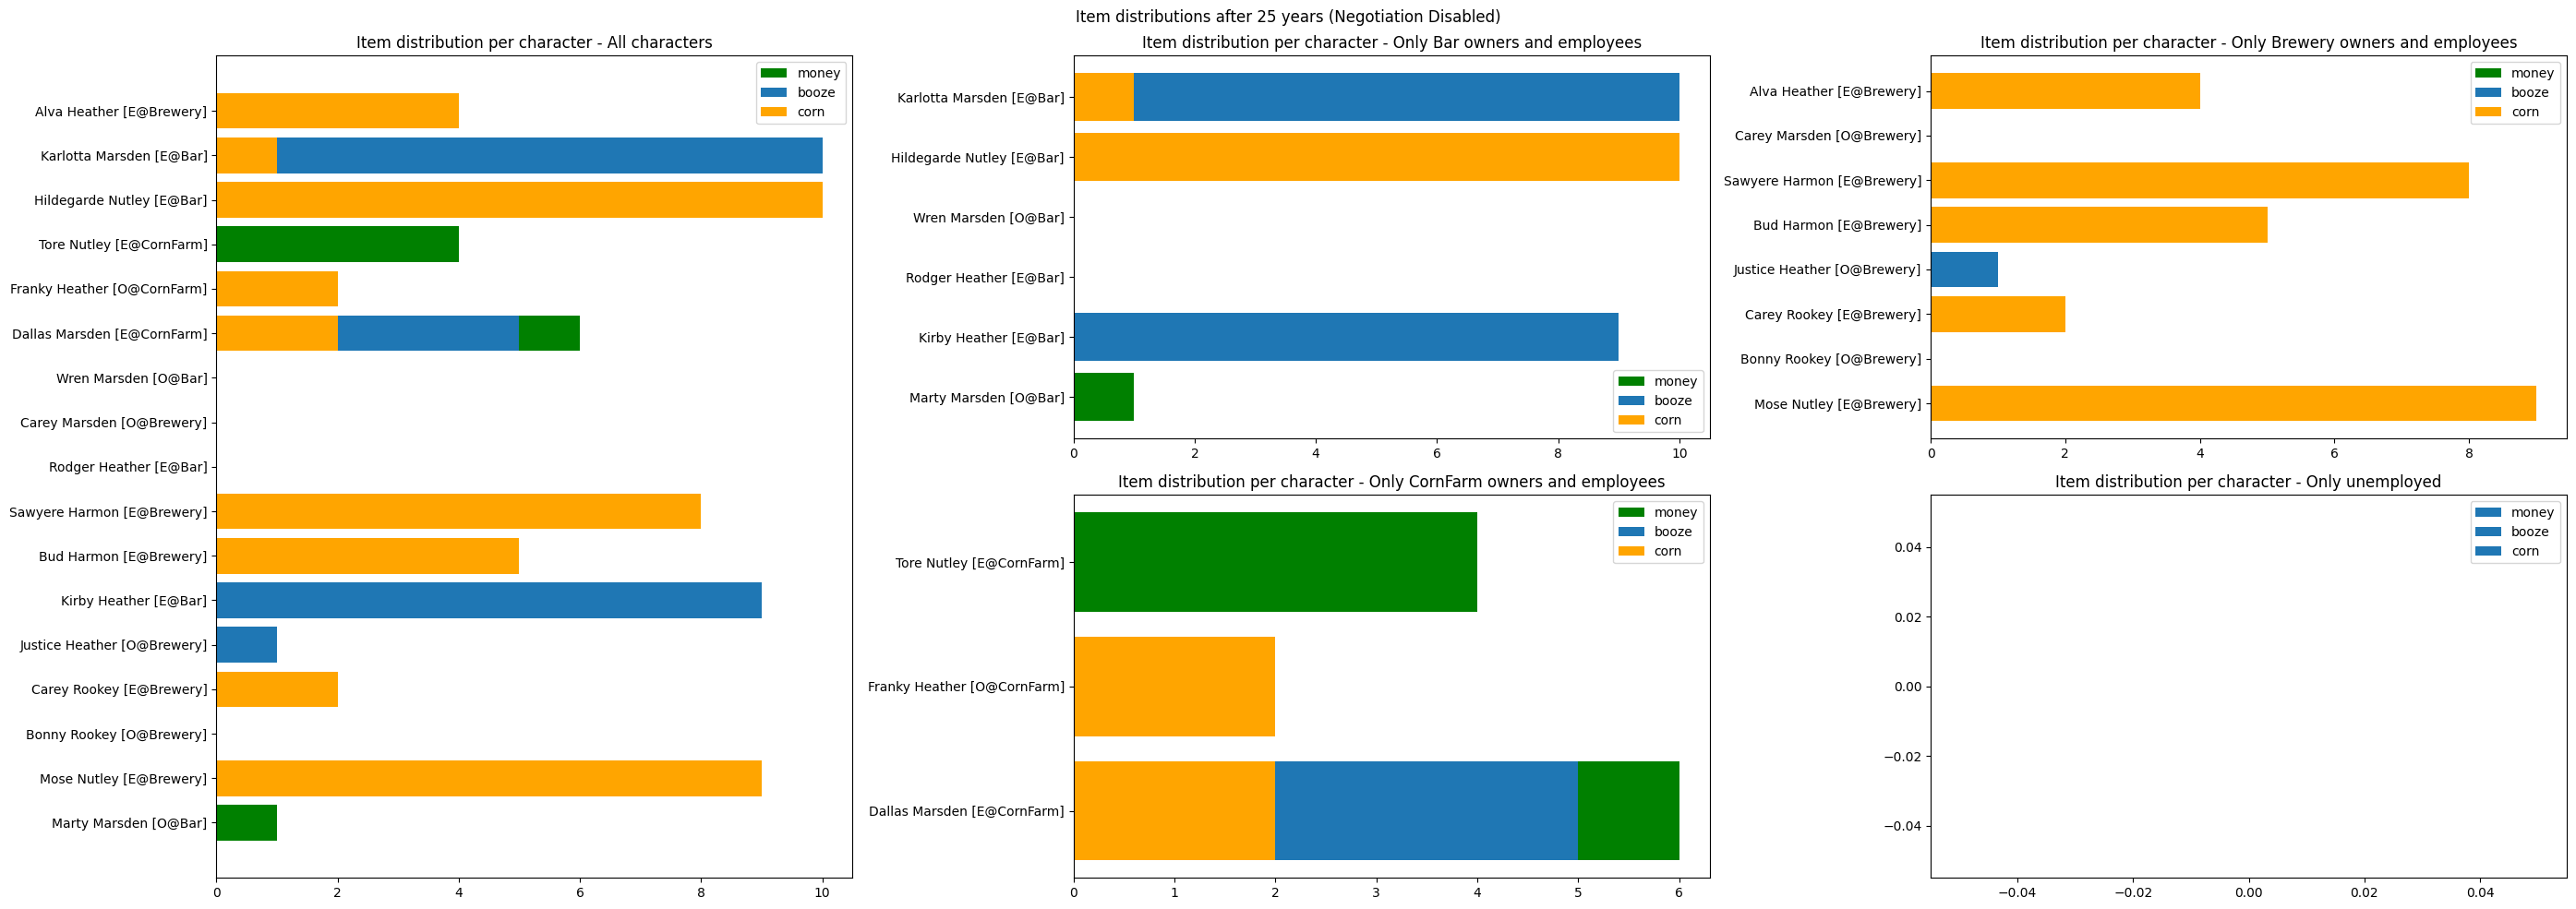

In [17]:
def show_item_distributions():
    colors = {'booze':'C0','corn':'orange','money':'green'}

    titles_ab = [f"Item distributions after {DURATION_SIMS_AB} years (Negotiation Enabled)", f"Item distributions after {DURATION_SIMS_AB} years (Negotiation Disabled)"]

    for idx, sim in enumerate(sims_ab):
        names, distributions, business_types = calculate_item_distributions(sim)
        
        fig = plt.figure(figsize=(28,10), constrained_layout=True)
        gs = GridSpec(2,3,figure=fig)

        ax1 = fig.add_subplot(gs[:,0])
        x_labels = names
        for dist in distributions.items():
            plt.barh(x_labels, dist[1], color=colors[dist[0]])
        plt.locator_params(axis="x", integer=True)
        plt.legend([str(k) for k in distributions.keys()])
        plt.title("Item distribution per character - All characters")

        
        business_types = list(business_types)
        business_types.sort()
        for i, type in enumerate(business_types):
            filtered_names = [n for n in names if type in n]
            index_list = [names.index(n) for n in filtered_names]
            filtered_distributions = dict((d[0], [d[1][i] for i in index_list]) for d in distributions.items())

            ax = fig.add_subplot(gs[i//2,1+i%2])
            x_labels = filtered_names
            for dist in filtered_distributions.items():
                plt.barh(x_labels, dist[1], color=colors[dist[0]])
            plt.locator_params(axis="x", integer=True)
            plt.legend([str(k) for k in filtered_distributions.keys()])
            if type == "None":
                plt.title(f"Item distribution per character - Only unemployed")
            else:
                plt.title(f"Item distribution per character - Only {type} owners and employees")
                
        plt.suptitle(titles_ab[idx])
        plt.tight_layout()
        plt.savefig(FILE_OUTPUT_LOCATION + "item_distributions_ab.png")
        plt.show()

show_item_distributions()

For the multi sims, we will look at average item distributions over certain populations:

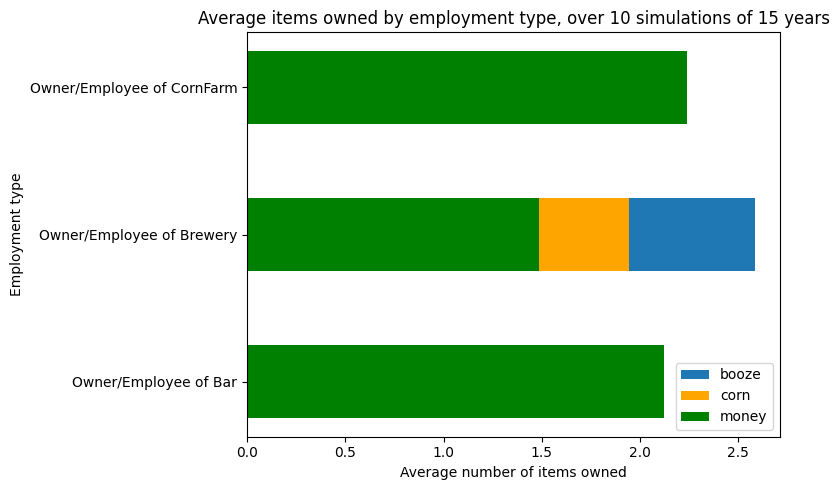

In [18]:
def show_item_distributions():
    colors = {'booze':'C0','corn':'orange','money':'green'}

    plt.figure(figsize=(8,5))

    item_labels = ["booze", "corn", "money"]
    business_types = ["Bar", "Brewery", "CornFarm"]

    for item in item_labels:
        ypositions = np.arange(len(business_types))

        data_per_sim = []
        for sim in sims_multi:
            data_per_btype = []
            for btype in business_types:
                names_i, distributions_i, _ = calculate_item_distributions(sim)
                matching_names = [n for n in names_i if btype in n]
                if len(matching_names) > 0:
                    indeces = [names_i.index(name) for name in matching_names]
                    dists = [distributions_i[item][index] for index in indeces]
                    data_per_btype.append(np.average(dists))
                else:
                    data_per_btype.append(0)
            data_per_sim.append(data_per_btype)

        business_type_labels = [(f"Owner/Employee of {b}" if b != "None" else "Unemployed") for b in business_types]

        data_per_sim = np.array(data_per_sim)
        data = np.average(data_per_sim, axis=0)
        plt.barh(y=ypositions, height=0.5, tick_label=business_type_labels, width=data, color=colors[item])
            
    plt.legend(item_labels)

    plt.title(f"Average items owned by employment type, over {NUM_SIMS_MULTI} simulations of {DURATION_SIMS_MULTI} years")
    plt.xlabel("Average number of items owned")
    plt.ylabel("Employment type")
    plt.tight_layout()
    plt.savefig("item_distributions_multi.png")
    plt.show()

show_item_distributions()

We can also visualize the occurence of certain trade pairs (e.g. corn-for-money, money-for-booze).

We count both `TradeEvent` and `NegotiateEvent` as "trade", as long as the negotiation involves items being exchanged:

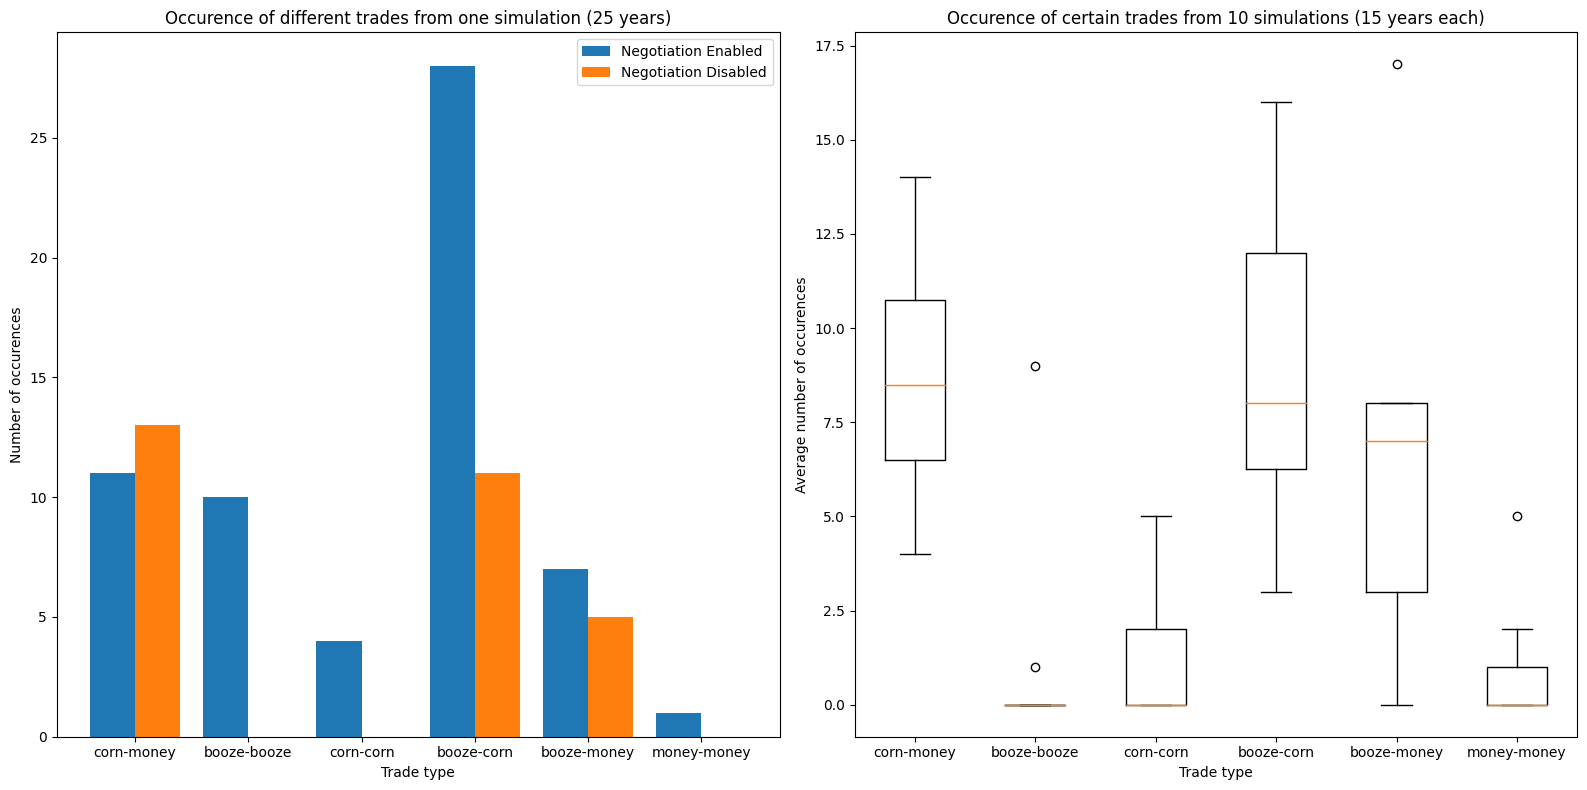

In [19]:
def show_trade_compositions():
    fig = plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    bar_width = 0.5
    bar_padding = 0.25

    comps_a = dict(calculate_trade_count_by_type(sims_ab[0]))
    comps_b = dict(calculate_trade_count_by_type(sims_ab[1]))
    
    trade_categories = [key for key in comps_a]
    trade_categories.extend([key for key in comps_b])

    trade_categories = list(set(trade_categories))

    positions = np.arange(len(trade_categories))

    plt.bar(x=positions*(1+bar_padding) - bar_width/2, width=bar_width, height=[(comps_a[category] if category in comps_a else 0) for category in trade_categories], tick_label=trade_categories, align="edge")

    plt.bar(x=positions*(1+bar_padding) + bar_width/2, width=bar_width, height=[(comps_b[category] if category in comps_b else 0) for category in trade_categories], tick_label=trade_categories, align="edge")
    
    plt.legend(["Negotiation Enabled", "Negotiation Disabled"])
    plt.title(f"Occurence of different trades from one simulation ({DURATION_SIMS_AB} years)")
    plt.xlabel("Trade type")
    plt.ylabel("Number of occurences")

    plt.subplot(1,2,2)

    comps_multi = [dict(calculate_trade_count_by_type(sim)) for sim in sims_multi]

    for comp in comps_multi:
        trade_categories.extend(list(comp.keys()))
    trade_categories = list(set(trade_categories))
    positions = np.arange(len(trade_categories))
    
    data = np.array([[(comp[category] if category in comp else 0) for category in trade_categories] for comp in comps_multi])
    #data = np.average(data, axis=0)
    #plt.bar(x=positions, width=bar_width, height=data, tick_label=trade_categories, align="center")
    plt.boxplot(data, labels=trade_categories)
    
    plt.title(f"Occurence of certain trades from {NUM_SIMS_MULTI} simulations ({DURATION_SIMS_MULTI} years each)")
    
    plt.xlabel("Trade type")
    plt.ylabel("Average number of occurences")
    plt.tight_layout()
    plt.savefig(FILE_OUTPUT_LOCATION + "trade_compositions.png")

show_trade_compositions()

### 3. What is the state of the relationships between characters?

We can use a few different methods to inspect the status of relationships between characters. 

First, we can look at histograms of the values of respect in each (unidirectional) relationship:

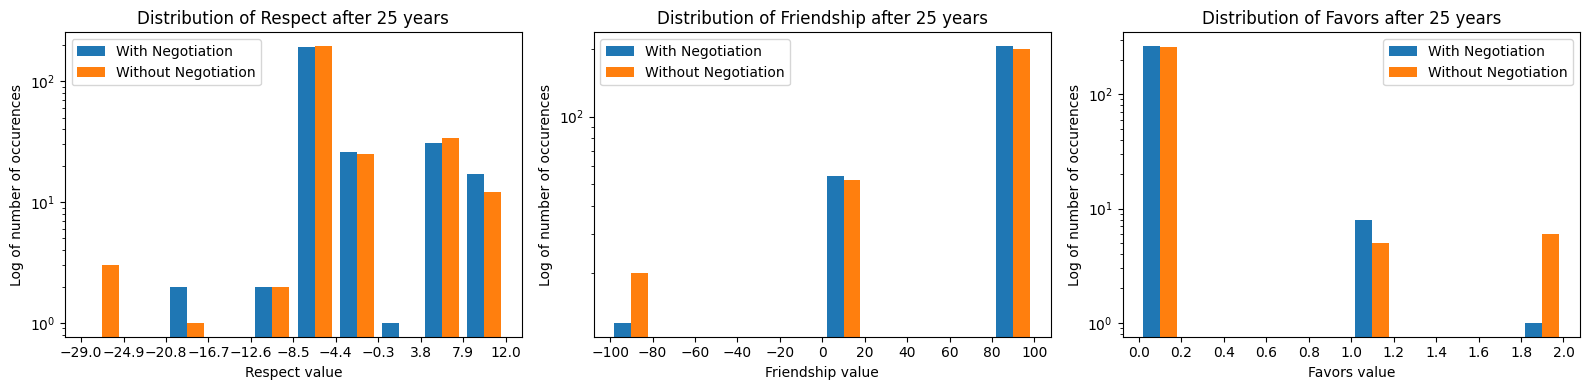

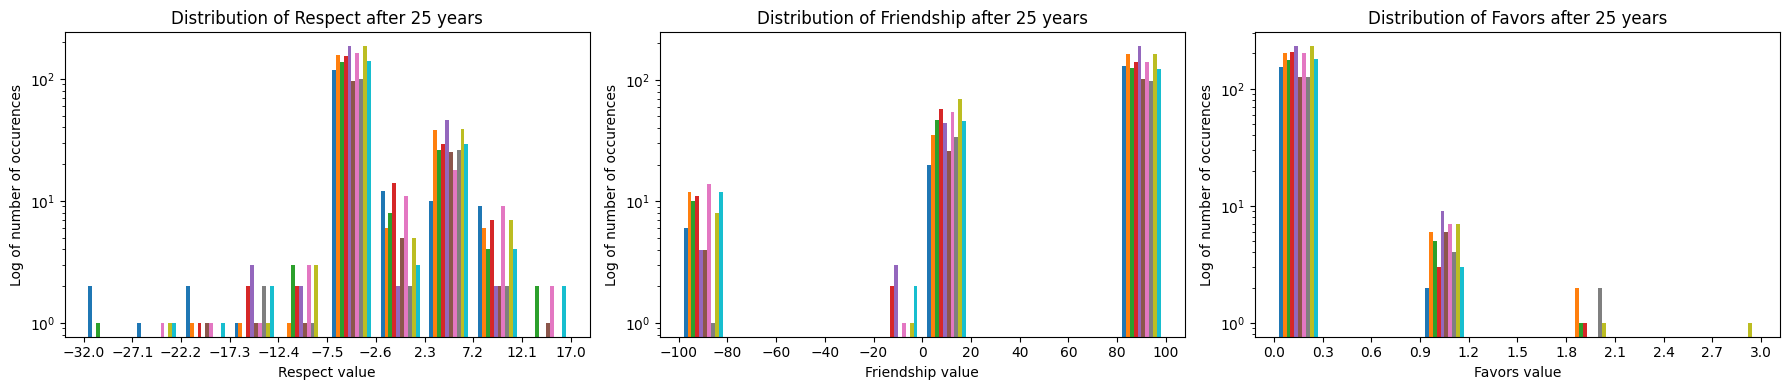

In [20]:
def show_relationship_histograms():
    respect_values_a = calculate_relationship_values(sims_ab[0])
    respect_values_b = calculate_relationship_values(sims_ab[1])

    fig = plt.figure(figsize=(16,4))
    relationship_distributions = [respect_values_a, respect_values_b]
    for idx, key in enumerate(relationship_distributions[0]):
        plt.subplot(1, 3, idx+1)
        counts, bins, patches = plt.hist([dist[key] for dist in relationship_distributions])
        plt.xticks(bins)
        plt.yscale('log')
        plt.xlabel(f'{key} value')
        plt.ylabel('Log of number of occurences')
        plt.legend(["With Negotiation", "Without Negotiation"])
        plt.title(f"Distribution of {key} after {DURATION_SIMS_AB} years")
    plt.tight_layout()
    plt.savefig(FILE_OUTPUT_LOCATION + "/relationship_distribution_ab.png")
    plt.show()

    fig = plt.figure(figsize=(18,4))
    relationship_distributions = [calculate_relationship_values(sim) for sim in sims_multi]
    for idx, key in enumerate(relationship_distributions[0]):
        plt.subplot(1, 3, idx+1)
        counts, bins, patches = plt.hist([dist[key] for dist in relationship_distributions])
        plt.xticks(bins)
        plt.yscale('log')
        plt.xlabel(f'{key} value')
        plt.ylabel('Log of number of occurences')
        plt.title(f"Distribution of {key} after {DURATION_SIMS_AB} years")
    plt.tight_layout()
    plt.savefig(FILE_OUTPUT_LOCATION + "/relationship_distribution_multi.png")
    plt.show()

show_relationship_histograms()

We can also create a graph visualization of the respect relationship between characters. 

First, for the AB sims, we will let each character be a graph node. We can create a graph of mutual (summed both ways) respect and use higher mutual respect to pull nodes together, driving a force-directed layout. We visualize positive mutual respect with edges, and thicker edges correspond to higher mutual respect. We use the size and color of each node to show that character's total incoming respect and ethnicity, respectively:

c:\Program Files (x86)\Python310\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'Justice Heather', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
c:\Program Files (x86)\Python310\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'Justice Heather', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


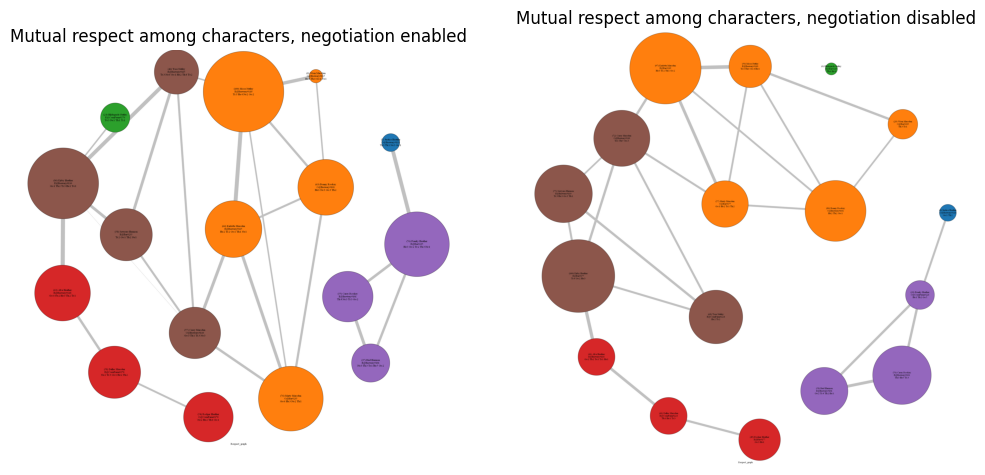

In [21]:
def show_relationship_graph_ab():
    names = ["negotiation enabled","negotiation disabled"]
    plt.figure(figsize=(12,6))
    for idx, sim in enumerate(sims_ab):
      g = make_relationship_graph(sim, Respect)
      plt.subplot(1,2,idx+1)
      display_graph(g, f"ab_{idx}", "Mutual respect among characters, " + names[idx])
    plt.savefig(FILE_OUTPUT_LOCATION + "mutual_respect_graph_ab.png")

show_relationship_graph_ab()

For both the AB and the multi sims, we will show mutual respect averaged among business owners of different ethnicities:

c:\Program Files (x86)\Python310\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'Bar&Black', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
c:\Program Files (x86)\Python310\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'Brewery&Asian', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


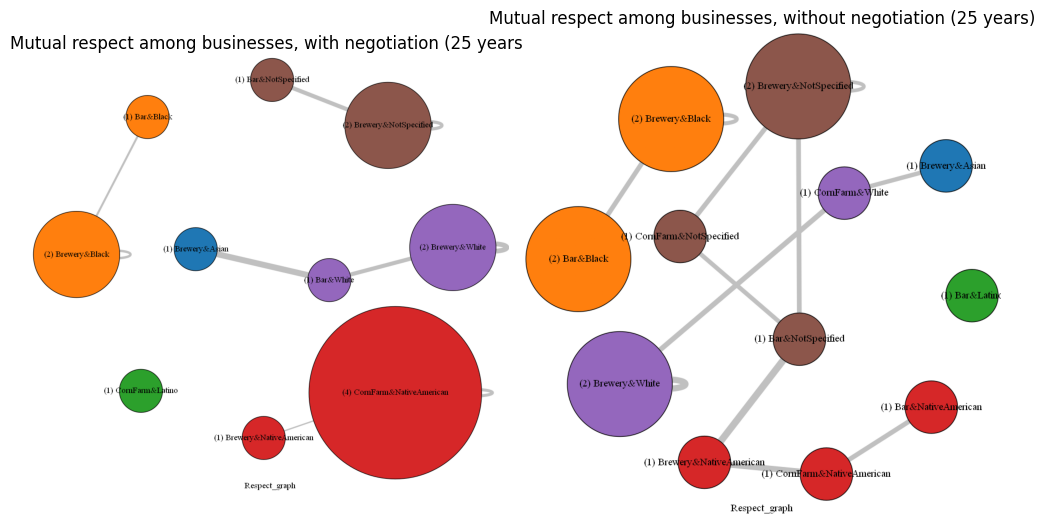

In [22]:
def show_relationship_graph_ab():
  plt.figure(figsize=(10,20))
  plt.subplot(1,2,1)
  g = make_business_relationship_graph([sims_ab[0]], Respect)
  display_graph(g, f"ab_neg", f"Mutual respect among businesses, with negotiation ({DURATION_SIMS_AB} years)")

  plt.subplot(1,2,2)
  g = make_business_relationship_graph([sims_ab[1]], Respect)
  display_graph(g, f"ab_no_neg", f"Mutual respect among businesses, without negotiation ({DURATION_SIMS_AB} years)")

  plt.tight_layout()
  plt.savefig(FILE_OUTPUT_LOCATION + "mutual_respect_graph_ab.png")
  
show_relationship_graph_ab()  

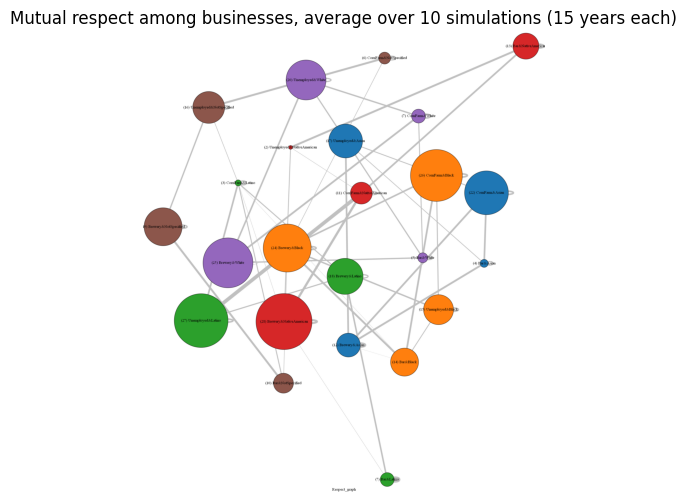

In [25]:
# ISSUE: this can take almost a full minute to run sometimes (n^2)
def show_relationship_graph_multi():
    plt.figure(figsize=(6,6))
    g = make_business_relationship_graph(sims_multi, Respect)
    display_graph(g, f"multi", f"Mutual respect among businesses, average over {NUM_SIMS_MULTI} simulations ({DURATION_SIMS_MULTI} years each)")
    plt.savefig(FILE_OUTPUT_LOCATION + "mutual_respect_graph_multi.png")

show_relationship_graph_multi()

Lastly, we can check whether their initiation of certain events correlates with a character's total incoming respect:

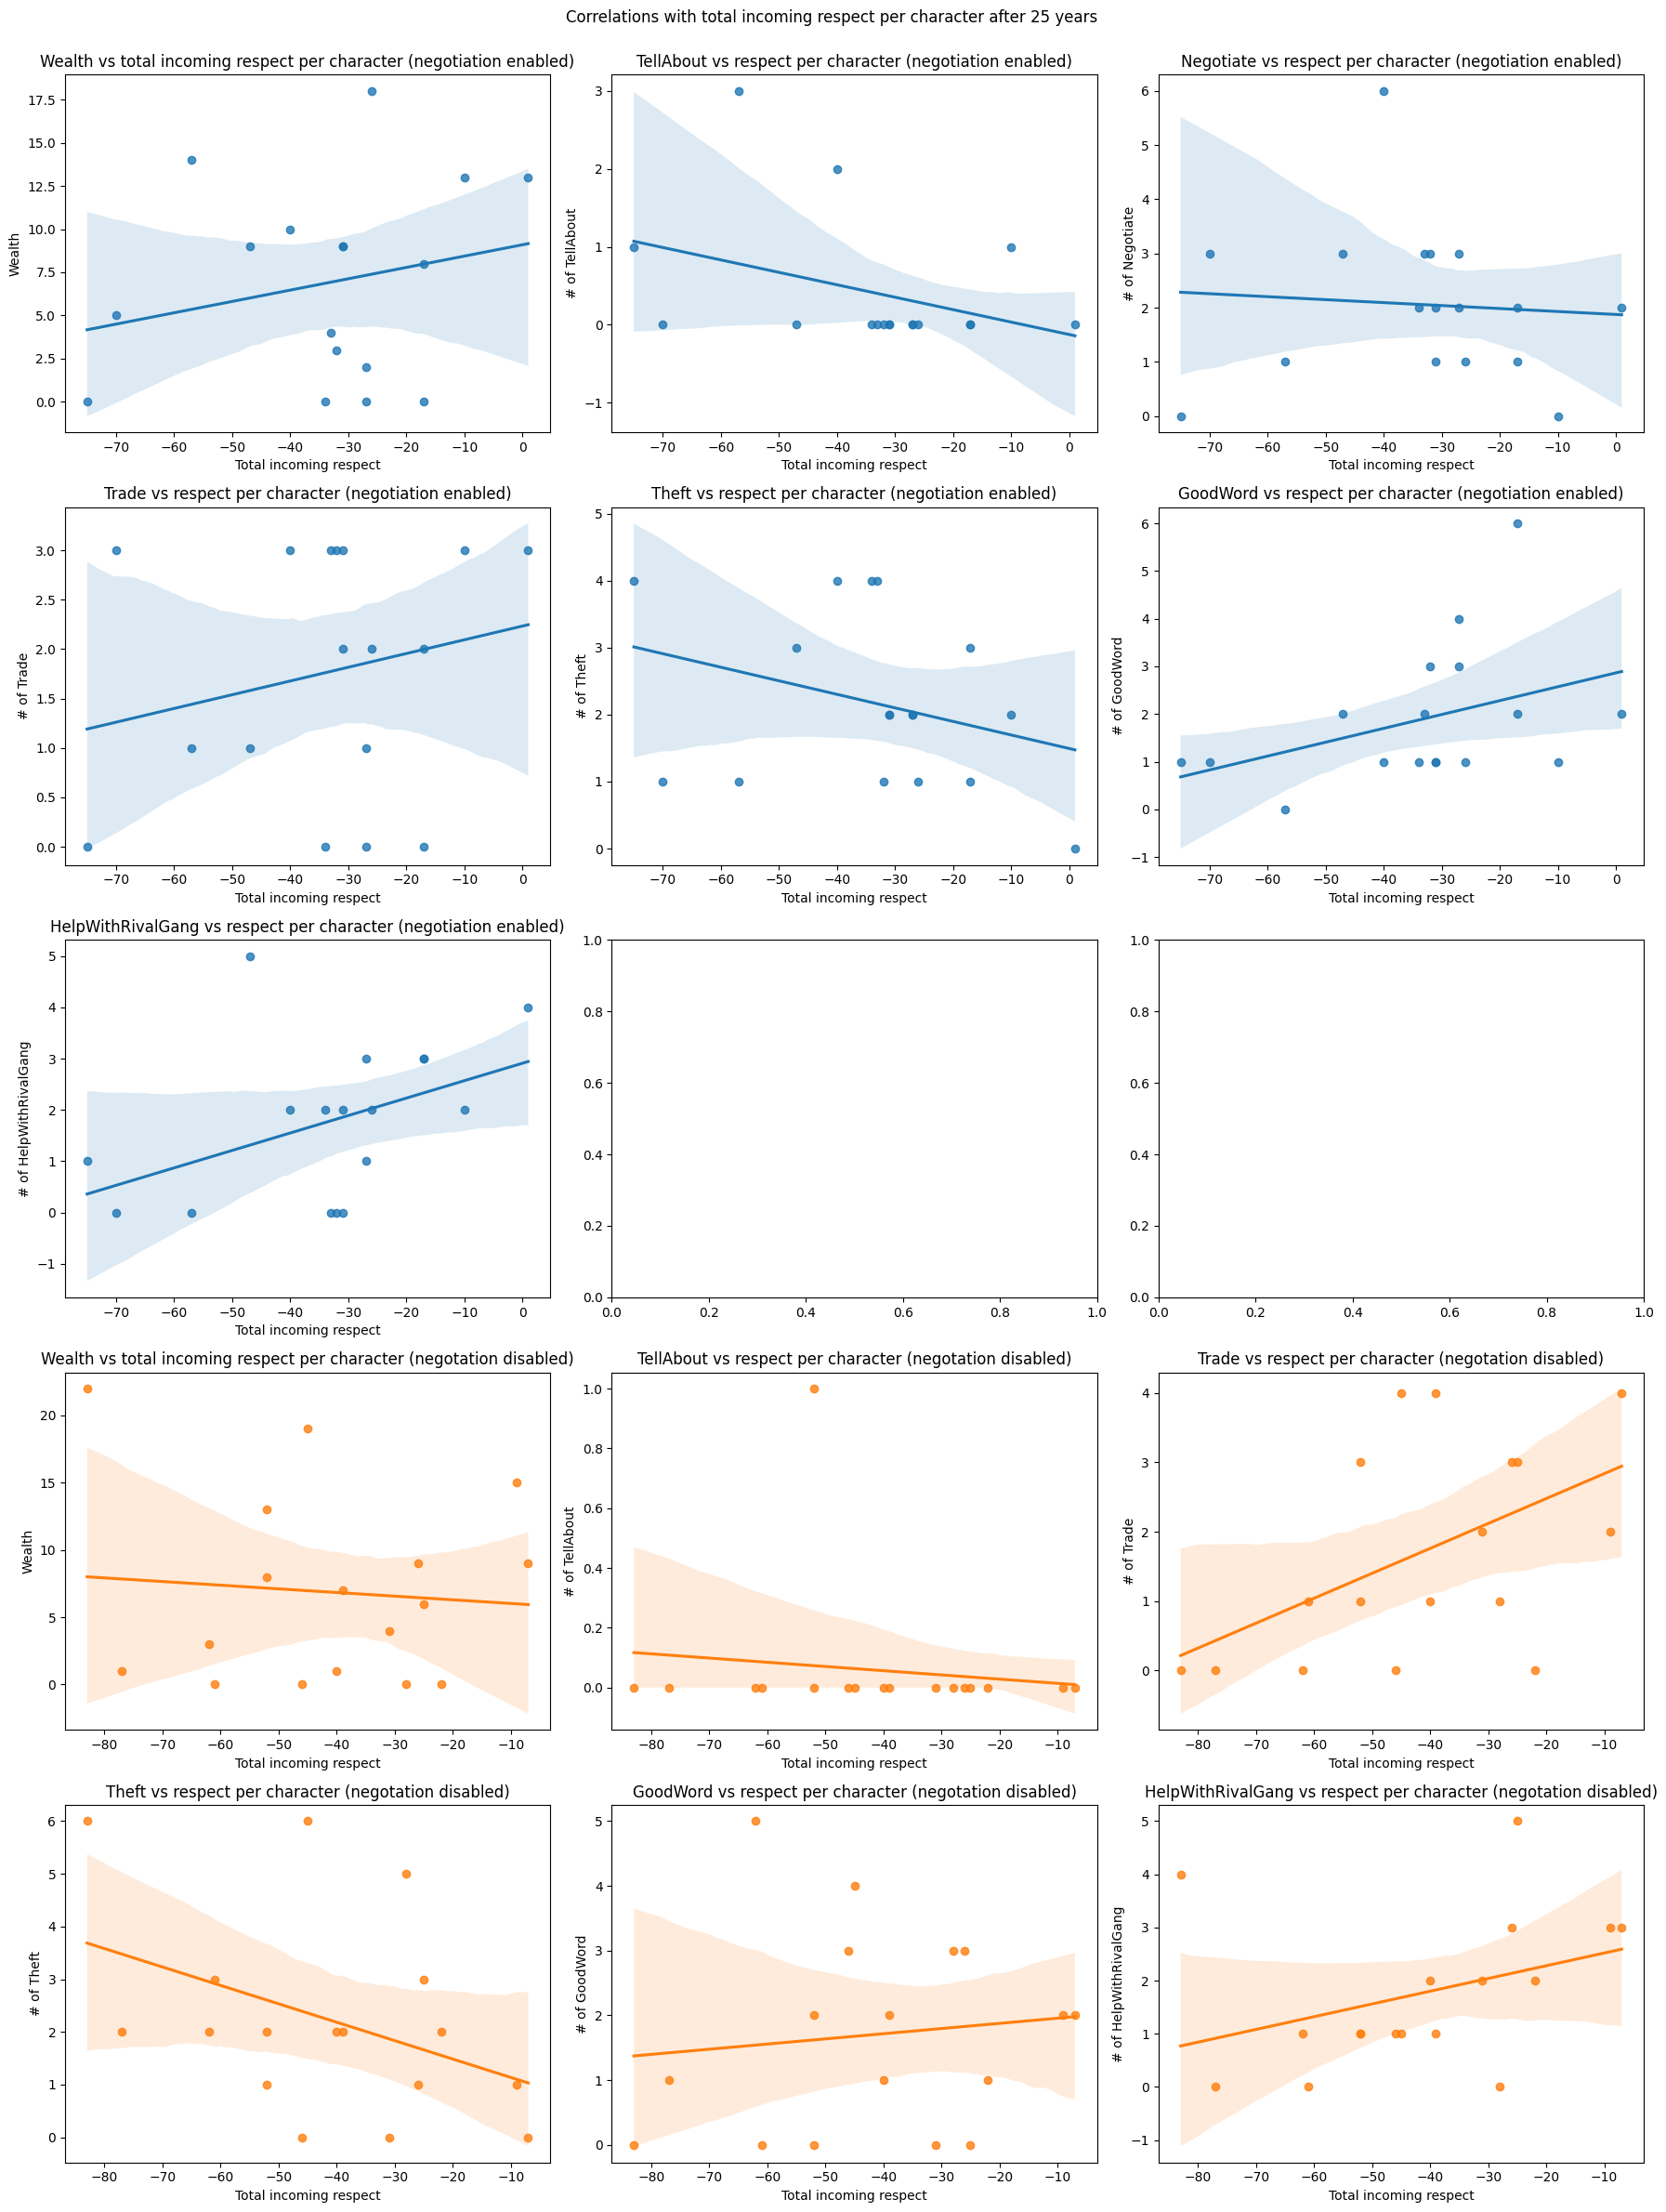

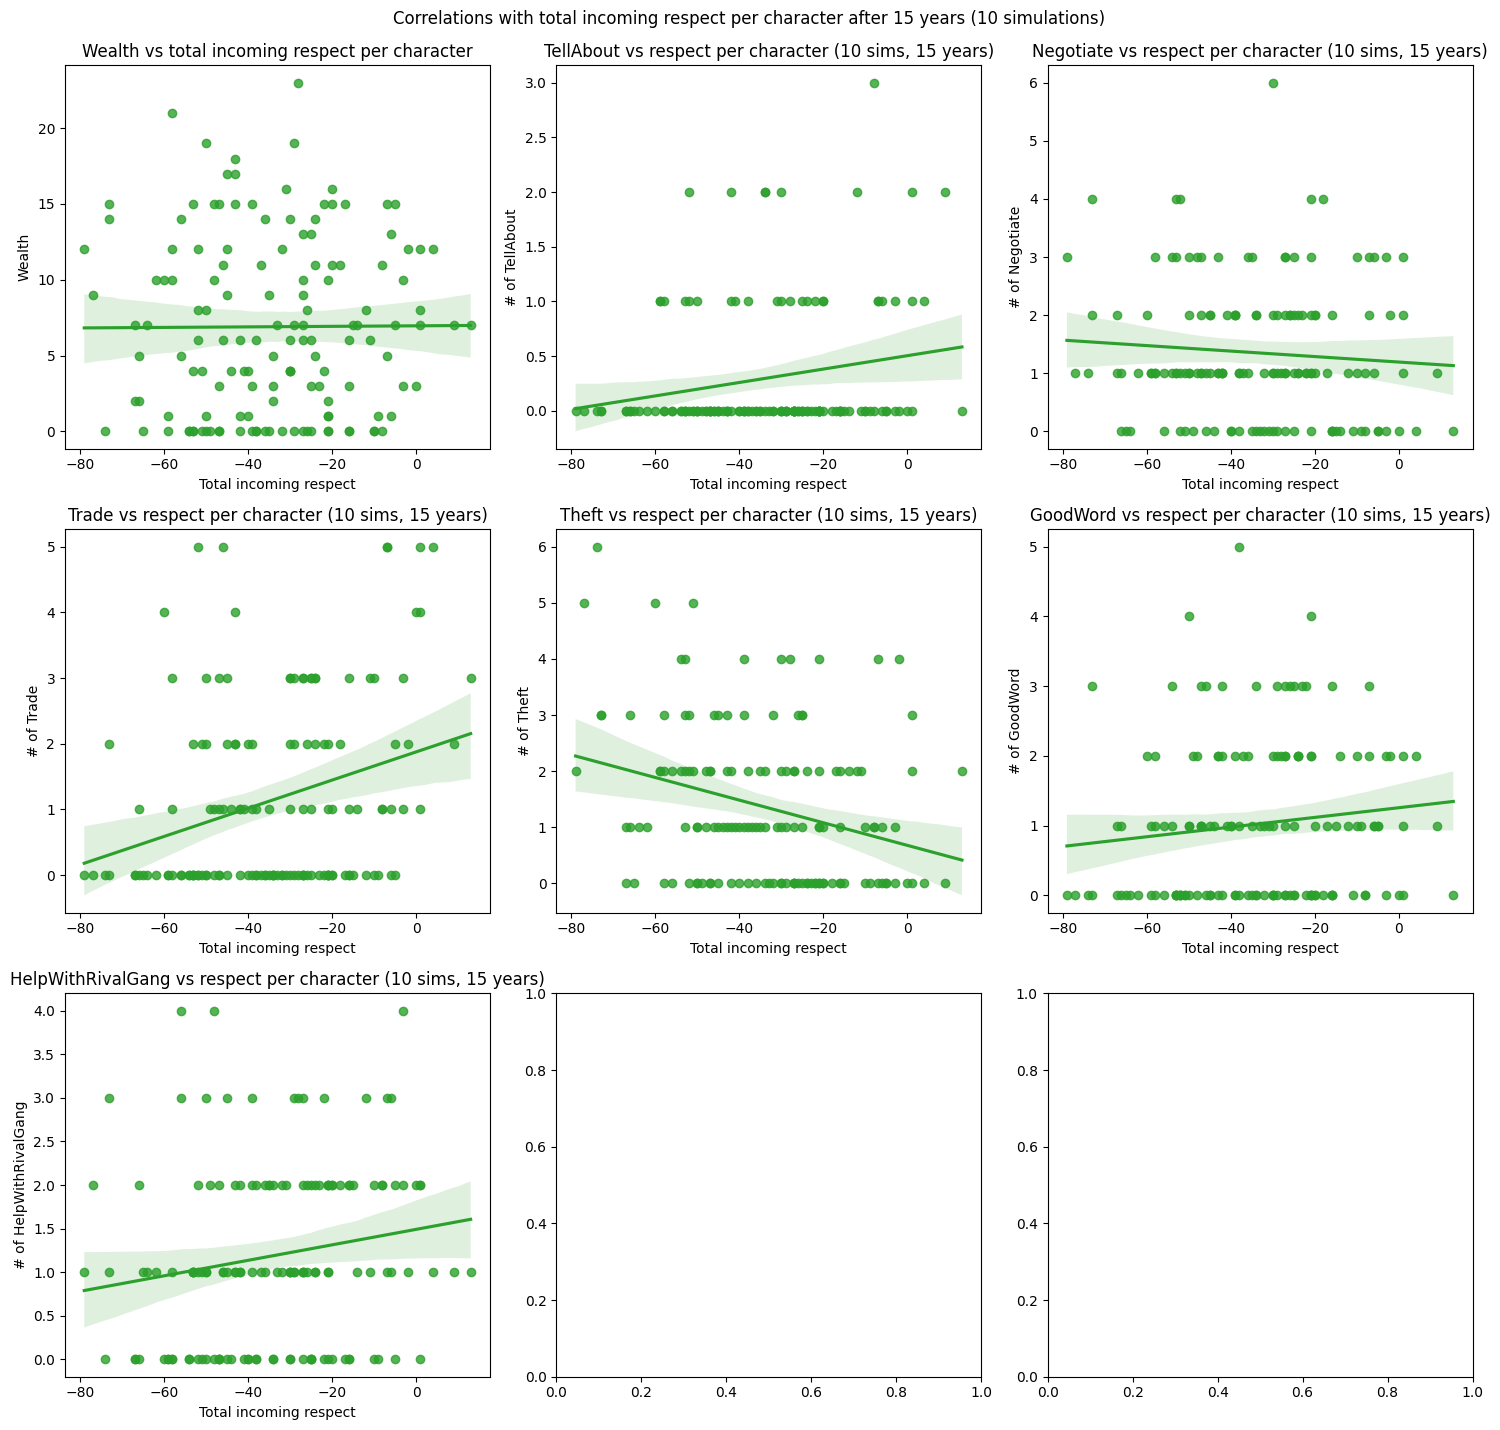

In [32]:
def show_respect_correlates():
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    sim_titles = ["negotiation enabled", "negotation disabled"]
    fig, axes = plt.subplots(5, 3, figsize=(18, 25))
    fig.suptitle(f"Correlations with total incoming respect per character after {DURATION_SIMS_AB} years")
    for idx, sim in enumerate(sims_ab):
      (respects, wealths, fs, cs, cs_keys) = calculate_respect_and_other_things_per_character(sim)
      grid_x = (9*idx)//3
      grid_y = (9*idx)%3
      sns.regplot(ax=axes[grid_x][grid_y], x=respects, y=wealths, color=colors[idx])
      axes[grid_x][grid_y].set_title(f"Wealth vs total incoming respect per character ({sim_titles[idx]})")
      axes[grid_x][grid_y].set(xlabel='Total incoming respect', ylabel='Wealth')

      for event_key_idx, event_key in enumerate(cs_keys):
        grid_x = (9*idx + 1 + event_key_idx)//3
        grid_y = (9*idx + 1 + event_key_idx)%3
        sns.regplot(ax=axes[grid_x][grid_y], x=respects, y=[(c[event_key] if event_key in c else 0) for c in cs], color=colors[idx])
        axes[grid_x][grid_y].set_title(f"{event_key[:-5]} vs respect per character ({sim_titles[idx]})")
        axes[grid_x][grid_y].set(xlabel='Total incoming respect', ylabel=f'# of {event_key[:-5]}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(FILE_OUTPUT_LOCATION + "/respect_correlations_ab.png")

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f"Correlations with total incoming respect per character after {DURATION_SIMS_MULTI} years ({NUM_SIMS_MULTI} simulations)")

    multi_respects = []
    multi_wealths = []
    multi_cs = []
    for idx, sim in enumerate(sims_multi):
      (respects, wealths, fs, cs, cs_keys) = calculate_respect_and_other_things_per_character(sim)
      multi_respects.extend(respects)
      multi_wealths.extend(wealths)
      multi_cs.extend(cs)

    sns.regplot(ax=axes[0][0], x=multi_respects, y=multi_wealths, color=colors[2])
    axes[0][0].set_title(f"Wealth vs total incoming respect per character")
    axes[0][0].set(xlabel='Total incoming respect', ylabel='Wealth')
    
    for event_key_idx, event_key in enumerate(cs_keys):
      grid_x = (1 + event_key_idx)//3
      grid_y = (1 + event_key_idx)%3
      sns.regplot(ax=axes[grid_x][grid_y], x=multi_respects, y=[(c[event_key] if event_key in c else 0) for c in multi_cs], color=colors[2])
      axes[grid_x][grid_y].set_title(f"{event_key[:-5]} vs respect per character ({NUM_SIMS_MULTI} sims, {DURATION_SIMS_MULTI} years)")
      axes[grid_x][grid_y].set(xlabel='Total incoming respect', ylabel=f'# of {event_key[:-5]}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.savefig(FILE_OUTPUT_LOCATION + "/respect_correlations_multi.png")

    
show_respect_correlates()